In [25]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [26]:
df1 = pd.read_csv('/Users/akshaysuryawanshi/PycharmProjects/Attribution-Phase2/ahs_mmnc.csv')
df2 = pd.read_csv('/Users/akshaysuryawanshi/PycharmProjects/Attribution-Phase2/ahs_mmc.csv')
df = pd.concat([df1,df2],axis=0)
print len(df)
print df.head(10)
#df = pd.read_csv('AHS Model/additional_test_data.csv')

188061
   ahs_date  zoom_account_no    account_name account_created_date  \
0  10/13/16           100038  Digitell, Inc.              1/14/16   
1  10/14/16           100038  Digitell, Inc.              1/14/16   
2  10/17/16           100038  Digitell, Inc.              1/14/16   
3  10/18/16           100038  Digitell, Inc.              1/14/16   
4  10/19/16           100038  Digitell, Inc.              1/14/16   
5  10/24/16           100038  Digitell, Inc.              1/14/16   
6  10/25/16           100038  Digitell, Inc.              1/14/16   
7  10/26/16           100038  Digitell, Inc.              1/14/16   
8  10/27/16           100038  Digitell, Inc.              1/14/16   
9  10/28/16           100038  Digitell, Inc.              1/14/16   

   account_age sales_group employee_count   coreproduct  currentterm  \
0          273          MM         51-250  Standard Pro            1   
1          274          MM         51-250  Standard Pro            1   
2          277   

In [27]:
#train, test = train_test_split(df, test_size = 0.3)
print df.columns[df.isnull().any()].tolist()

##################################################
currentterm_bins = [0,11,3000]
currentterm_bins_names = ['Month_Currentterm', 'Annual_Currentterm']
df['current_term'] = pd.cut(df['currentterm'], currentterm_bins, labels=currentterm_bins_names)
df = df.drop(['currentterm'],axis = 1)
print pd.value_counts(df['current_term'].values, sort=False)

##################################################
mrr_bins = [0,14.99,100,10000000000000]
mrr_group_names = ['MRR_14.99', 'MRR_100', 'MRR_100+']
df['mrr_exit_range'] = pd.cut(df['mrr_exit'], mrr_bins, labels=mrr_group_names)
df = df.drop(['mrr_exit'],axis = 1)
print pd.value_counts(df['mrr_exit_range'].values, sort=False)

###################################################
account_age_bins = [0,30,60,90,180,270,360,5000]
account_age_names = ['0-30 Days', '30-60 Days', '60-90 Days', '90-180 Days', '180-270 Days','270-360 Days','360+ Days']
df['account_age_range'] = pd.cut(df['account_age'], account_age_bins, labels=account_age_names)
df = df.drop(['account_age'],axis = 1)
print pd.value_counts(df['account_age_range'].values, sort=False)

['account_name', 'billtostate']


Month_Currentterm     106903
Annual_Currentterm     81158
dtype: int64


MRR_14.99    114246
MRR_100       31064
MRR_100+      42039
dtype: int64


0-30 Days         3361
30-60 Days        3577
60-90 Days        3435
90-180 Days       8223
180-270 Days     26912
270-360 Days    127299
360+ Days        15254
dtype: int64


In [28]:
print (df.columns).tolist()

['ahs_date', 'zoom_account_no', 'account_name', 'account_created_date', 'sales_group', 'employee_count', 'coreproduct', 'data_com_industry', 'billtostate', 'billtocountry', 'mrr_growth_30', 'mrr_growth_60', 'mrr_growth_90', 'mrr_growth_180', 'billing_hosts', 'paid_user_count', 'billing_hosts_utilization', 'paid_user_mau', 'paid_user_utilization', 'free_user_count', 'free_user_mau', 'free_user_utilization', 'total_zr_deployed', 'total_meetings_last_30', 'total_minutes_last_30', 'meetings_per_user_last_30', 'minutes_per_user_last_30', 'total_minutes_per_meeting_last_30', 'paid_meetings_last_30', 'paid_minutes_last_30', 'paid_meetings_per_user_last_30', 'paid_minutes_per_user_last_30', 'paid_minutes_per_meeting_last_30', 'free_meetings_last_30', 'free_minutes_last_30', 'free_meetings_per_user_last_30', 'free_minutes_per_user_last_30', 'free_minutes_per_meeting_last_30', 'zr_meetings_last_30', 'zr_minutes_last_30', 'zr_meetings_per_zr_last_30', 'zr_minutes_per_zr_last_30', 'zr_minutes_per_

In [29]:
df = df.drop(['ahs_date', 'account_name', 'account_created_date','billtocountry', 'billtostate',
                          'churn_downsell', 'churn_cancel', 'churn_gross', 
                          'churn_downsell_next_90', 'churn_cancel_next_90'], axis=1)

In [30]:
target = 'churn_gross_next_90'
IDcol = 'zoom_account_no'
cat_cols = ['sales_group','employee_count','data_com_industry','coreproduct', 'current_term','mrr_exit_range','account_age_range']
#num_cols= list(set(list(df.columns))-set(cat_cols)-set(IDcol)-set(target))

#create label encoders for categorical features
for var in cat_cols:
 number = LabelEncoder()
 df[var] = number.fit_transform(df[var].astype('str'))

In [31]:
train, test = train_test_split(df, test_size = 0.40)
print len(train)
print len(test)

112836
75225


In [32]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['churn_gross_next_90'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['churn_gross_next_90'], cv=cv_folds, scoring='roc_auc')
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['churn_gross_next_90'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['churn_gross_next_90'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['churn_gross_next_90'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8936
AUC Score (Train): 0.879442
CV Score : Mean - 0.8749538 | Std - 0.001618228 | Min - 0.8737167 | Max - 0.8780762


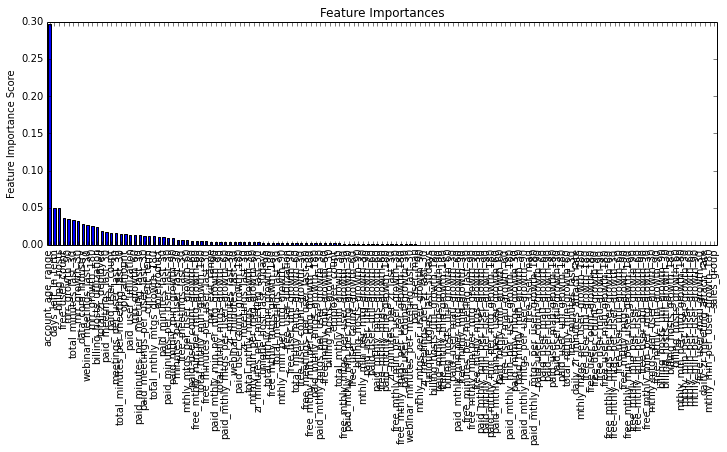

In [33]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

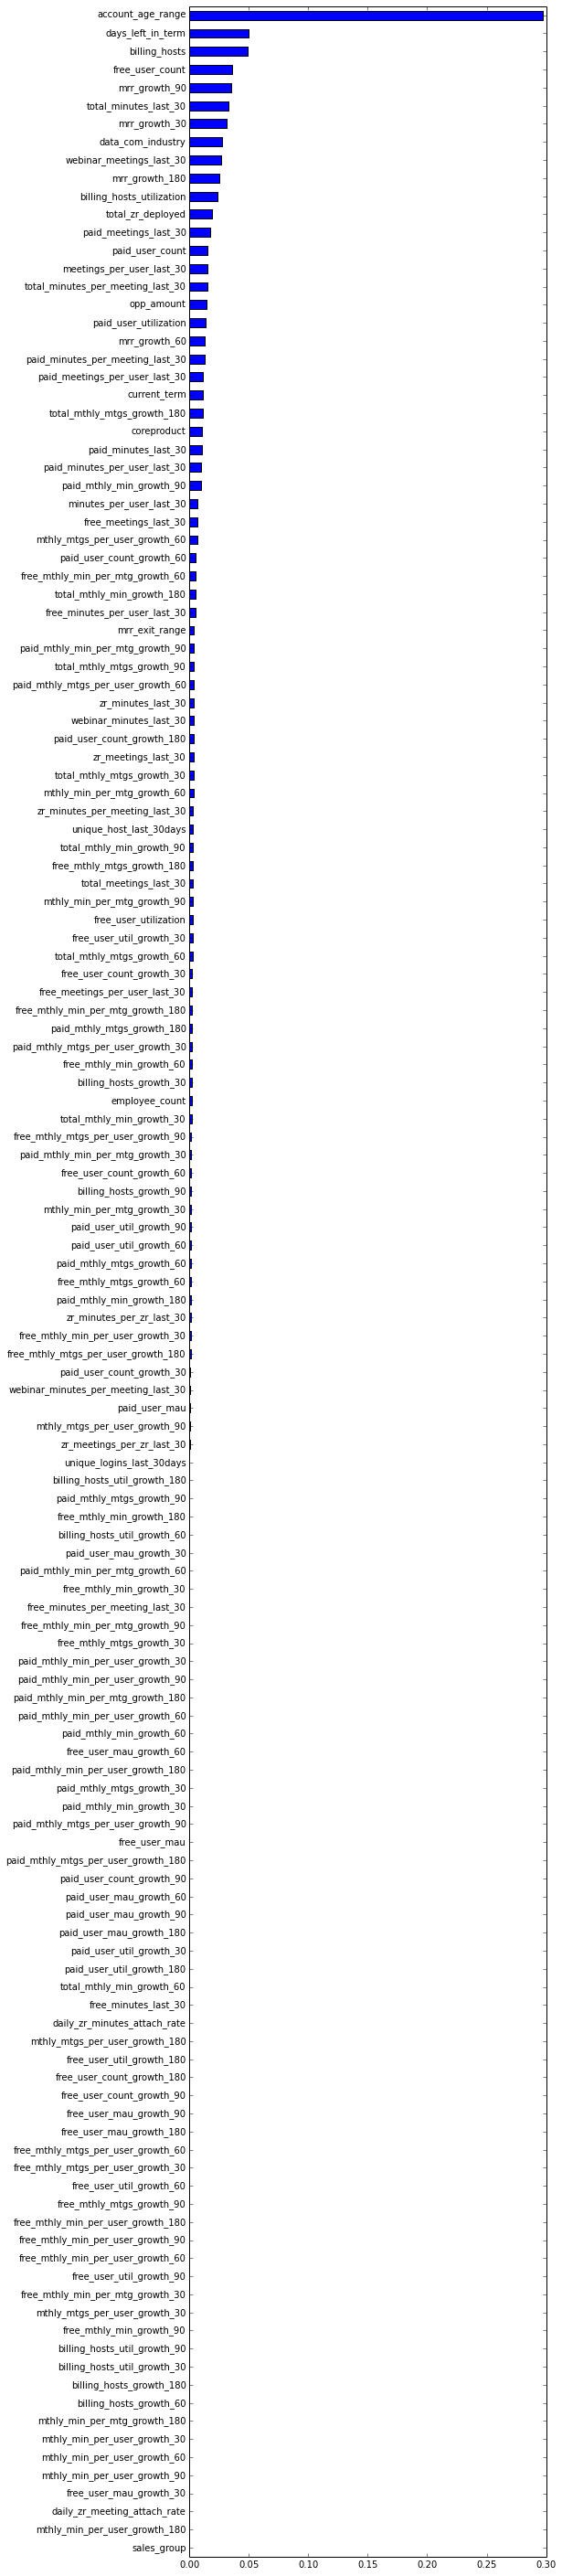

In [34]:
#features=list(set(list(df.columns))-set(IDcol)-set(target))
feature_importance = pd.Series(gbm0.feature_importances_, predictors).sort_values(ascending=True)
#pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
feature_importance.plot(kind = 'barh', figsize = (7,50))